# CNN+LRao detector: Magnetic signal detection example

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import CNN_LRao_functions as f
# %matplotlib widget
device = "cuda" if torch.cuda.is_available() else "cpu"
import warnings
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning
)

### Load and normalize data

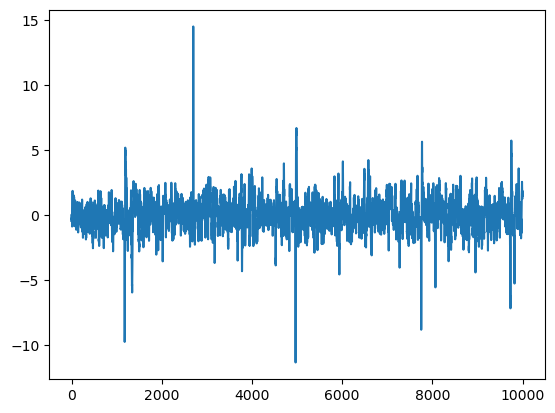

In [2]:
mat = sp.io.loadmat('FSSP3exer14_1.mat')
data = mat["w"].squeeze()
sigma_mad = 1.483*np.median(np.abs(data-np.median(data)))
data = (data-np.median(data))/sigma_mad
plt.figure()
plt.plot(data)

### Hyperparameters

In [3]:
config = {
    "optim": ["AdamW"],# optimizer pytorch for CNN weights,"Adam","SGD","AdamW"
    "lr": [1e-4], # learning rate optimizer
    "weight_decay": 1e-5, # L2 weight decay optimizer
    "dim_inp": 128, # CNN input dimension (sequence length)
    "psd_method_params": [{"name":"periodogram"}],# PSD estimation method, {"name":"yule","order":5},{"name":"yule","order":7},{"name":"yule","order":10},{"name":"periodogram"}
    "max_iterations": 500, # max number of iterations (batches and epochs, since batchsize = whole data set)
    "da": 1e-2, # step size for computation of Jacobian of mean
    "filt_size":[3], # CNN filter size
    "n_hidden_channels": [20], # CNN number of hidden channels
    "n_conv_layers": [3], # CNN number of layers (including input and output)
    "puffer_sides": 10 # puffer on sides of input layer for calculation of gradient to eliminate edge effects
}

config_list = f.gen_list_models(config) # list of config dicts
K = 4 # number of harmonics
psi0 = 0.1 # normalized fundamental frequency
H = f.H_multi_harmonic(K,psi0,config["dim_inp"]).to(device) # observation matrix train
n_SNR = 20 # number of considered SNR levels
snr = torch.logspace(-3.5,-1.5,n_SNR) # SNR levels
p_data = np.mean(data**2) # variance of data
amplitudes = torch.sqrt(2*p_data*snr/K) # amplitudes according to SNR levels
n_splits_o = 5 # outer cross validation splits, in paper:10
n_repeats_o = 1 # outer cross validation repeats
n_splits_i = 4 # inner cross validation splits in paper:9
n_repeats_i = 1 # inner cross validation repeats
n_repeats_phase_net = 10 # evaluation repeats for different phases, in paper:100
data_torch = torch.tensor(data,device=device,dtype=torch.float32)
data_torch_reshaped = f.reshape_data(data_torch,config["dim_inp"])

### Train, validate, and test model

In [ ]:
t0, t1, lambda_nc, lfi, config_best = f.nested_cv(data_torch_reshaped,H,amplitudes,config_list,n_splits_o,n_repeats_o,n_splits_i,n_repeats_i,n_repeats_phase_net)

Text(0.5, 1.0, 'LFI train until early stopping')

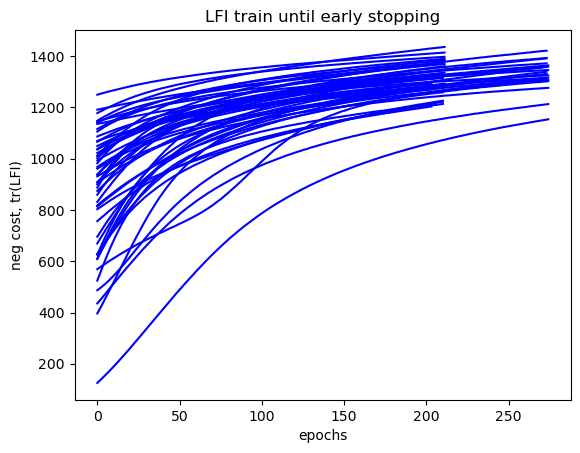

In [5]:
plt.figure() # LFI of training runs until early stopping
for i in range(len(lfi)):
    plt.plot(lfi[i],color="b")
plt.ylabel("neg cost, tr(LFI)")
plt.xlabel("epochs")
plt.title("LFI train until early stopping")

Text(0, 0.5, 'probability density')

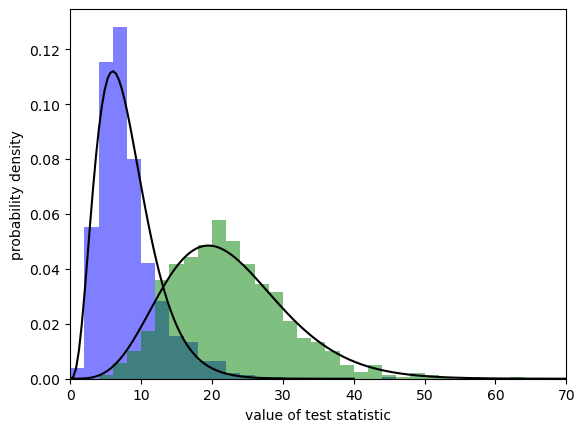

In [6]:
plt.figure()
binwidth = 2
idx_ = 9
plt.hist(t0.cpu(),density=True,alpha=0.5,color="blue",bins=np.arange(0,70+binwidth,binwidth))
plt.plot(np.linspace(0,40,100),sp.stats.chi2.pdf(np.linspace(0,40,100),8),color="k")
plt.hist(t1[idx_].cpu(),density=True,alpha=0.5,color="green",bins=np.arange(0,70+binwidth,binwidth))
plt.plot(np.linspace(0,80,200),sp.stats.ncx2.pdf(np.linspace(0,80,200),8,lambda_nc[idx_]),color="k")
plt.xlim(0,70)
plt.xlabel("value of test statistic")
plt.ylabel("probability density")

### Reference Models

In [7]:
t0_RaoCGN,t1_RaoCGN,t0_RaoCGN_clipped,t1_RaoCGN_clipped,t0_RaoWGN,t1_RaoWGN = f.reference_detection(data_torch_reshaped,H,amplitudes,n_splits_o,n_repeats_o,n_repeats_phase_net)

### ROCs: Average ROC and std dev of AUROC

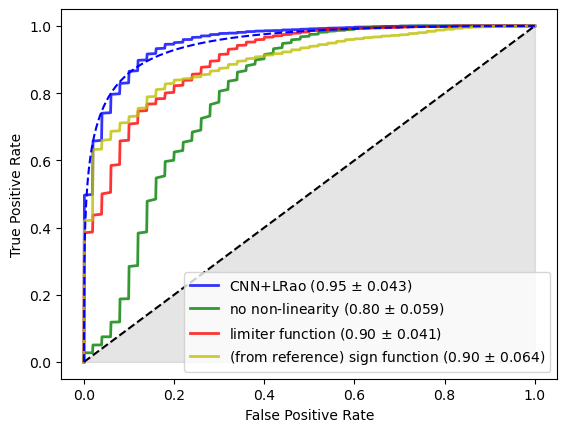

In [12]:
n_independent_test_data = len(data)//config["dim_inp"]
mean_fpr = np.linspace(0, 1, 1000)
n_indiv = 50 # has to be smaller than
n_trials = 100 #in paper: 1000
def tprs_aucs(t0,t1):
    tprs = []
    aucs = []
    for i in range(n_trials):
        tpr, fpr = f.calc_roc_statistics(torch.tensor(np.random.choice(t0, n_indiv, replace=False)),torch.tensor(np.random.choice(t1, n_indiv, replace=False)))
        interp_tpr = np.interp(mean_fpr, torch.flip(fpr,dims=[0]), torch.flip(tpr,dims=[0]))
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(f.auroc(fpr,tpr,fpr_max=1))
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)*(np.sqrt(n_indiv/n_independent_test_data))
    mean_auc = f.auroc(torch.tensor(mean_fpr), torch.tensor(mean_tpr))
    std_auc = np.std(aucs)
    return mean_tpr, std_tpr, mean_auc, std_auc

# CNN+LRao
idx = 9
fig, ax = plt.subplots()
mean_tpr, std_tpr, mean_auc, std_auc = tprs_aucs(t0,t1[idx])
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"CNN+LRao (%0.2f $\pm$ %0.3f)" % (mean_auc, 2*std_auc),
    lw=2,
    alpha=0.8,
)
tprs_upper = np.minimum(mean_tpr+2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr-2*std_tpr, 0)

mean_tpr, std_tpr, mean_auc, std_auc = tprs_aucs(t0_RaoCGN,t1_RaoCGN[idx])
ax.plot(
    mean_fpr,
    mean_tpr,
    color="g",
    label=r"no non-linearity (%0.2f $\pm$ %0.3f)" % (mean_auc, 2*std_auc),
    lw=2,
    alpha=0.8,
)
tprs_upper = np.minimum(mean_tpr+2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr-2*std_tpr, 0)

mean_tpr, std_tpr, mean_auc, std_auc = tprs_aucs(t0_RaoCGN_clipped,t1_RaoCGN_clipped[idx])
ax.plot(
    mean_fpr,
    mean_tpr,
    color="r",
    label=r"limiter function (%0.2f $\pm$ %0.3f)" % (mean_auc, 2*std_auc),
    lw=2,
    alpha=0.8,
)
tprs_upper = np.minimum(mean_tpr+2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr-2*std_tpr, 0)

mean_tpr, std_tpr, mean_auc, std_auc = tprs_aucs(t0_RaoWGN,t1_RaoWGN[idx])
ax.plot(
    mean_fpr,
    mean_tpr,
    color="y",
    label=r"(from reference) sign function (%0.2f $\pm$ %0.3f)" % (mean_auc, 2*std_auc),
    lw=2,
    alpha=0.8,
)
tprs_upper = np.minimum(mean_tpr+2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr-2*std_tpr, 0)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right")
ax.fill_between(
    [0,1],
    [0,0],
    [0,1],
    color="grey",
    alpha=0.2,
)
ax.plot([0,1],[0,1],"k--")
thresholds = sp.stats.chi2.isf(mean_fpr,df=2*K)
pd = sp.stats.ncx2.sf(thresholds,df=2*K,nc=lambda_nc[idx])
ax.plot(mean_fpr,pd,"b--")